# Graph coloring

------------------------------------------------------------
## Online resources and software environment

This document is hosted online as [Jupyter notebook](https://www.lix.polytechnique.fr/~will/Software/Infrared/current/Doc/GraphColoring.ipynb) with precomputed results. Download this file to view, edit and run examples in Jupyter.

We recommend to install all required software using Mamba (or Conda) and PIP.
```
mamba create -n infrared -c conda-forge infrared jupyter jupytext matplotlib seaborn graphviz
mamba activate infrared
pip install graphviz
mamba deactivate infrared
```

Start the Jupyter notebook server after activating the environment
```
mamba activate infrared
jupyter notebook
```
The [original sources](https://gitlab.inria.fr/amibio/Infrared/-/tree/master/Doc/Examples) are part of the Infrared distribution and hosted on Gitlab (in Jupytext light Script format).

------------------------------------------------------------

## The graph coloring problem
As a toy example for the use of Infrared, we model (a small instance) of graph coloring. The graph coloring model
defines variables for the graph nodes, whose possible values are the colors. Furthermore, we define inequality constraints for every edge, to ensure that connected nodes receive different colors in valid solutions.

This model is then extended by an objective function that counts the different colors in cycles of size four.
From the model, we create an Infrared solver to find optimal solutions. 

For instructional purposes, we furthermore show the dependency graph of the model and the tree decomposition used by the solver.

In [1]:
import infrared as ir

# specify the graph coloring instance
numcolors = 4 # colors 0..3
numnodes = 9 # nodes 1..9
edges = [(1,5),(2,3),(2,5),(2,7),(3,6),(5,6),(5,7),(5,8),(5,9),(6,8),(6,9),(7,8)]

# recall that we extend the standard graph coloring problem by counting different colors in cycles
cycles = [(2,3,5,6),(2,5,7,8),(5,6,7,8),(5,6,8,9)]

## Modeling in Infrared
Setup the model and construct a solver. Report the treewidth.

In [2]:
model = ir.Model()

# Note: to keep this example simple, we add a dummy variable
# with index 0. In this way, we can use the 1-based node indices
# as variable indices (without the need for index transformations)
model.add_variables(1,(0,0))

# Add one variable per node
model.add_variables(numnodes,numcolors)

# define NotEquals constraints in Python
ir.def_constraint_class('NotEquals',
    lambda i,j: [i,j], # signature and dependencies
    lambda x, y: x!=y)  # constraint semantics

# add one inequality constraint per edge 
model.add_constraints(NotEquals(i,j) for i,j in edges)

# define cardinality for sets of 4 variables
ir.def_function_class('Card', # define "cardinality"
    lambda i, j, k, l: [i,j,k,l], # signature, dependencies
    lambda x,y,z,w: len({x,y,z,w}))  # function evaluation

# add the cardinality function for every cycle
model.add_functions([Card(i,j,k,l) for i,j,k,l in cycles], 'card')

model.set_feature_weight(-1,'card') # set up in order to *minimize*

solver = ir.Optimizer(model)
print(f'Tree width: {solver.treewidth()}')

Tree width: 4


## Drawing the dependency graph of the model

Please ignore the dummy node 0 - we don't suppress it to keep things simple. Otherwise, the dependency graph is identical to the input graph as specified above.

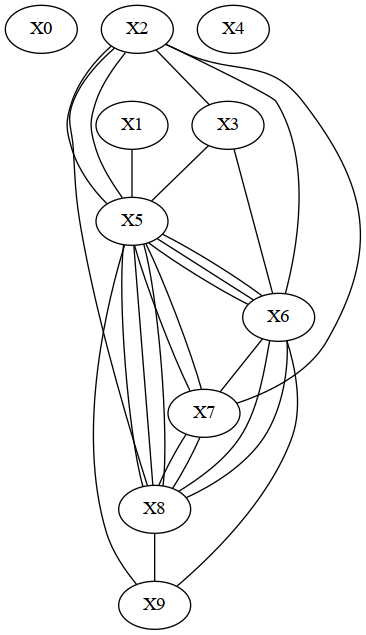

In [3]:
from IPython.display import Image
import re

# Plot dependency graph
filename = 'dependency_graph.dot'
model.write_graph(filename, True)

ir.dotfile_to_png(filename)
filename = re.sub(r"dot$","png",filename)

Image(filename=filename,width=300)

## Plotting the tree decomposition

This shows the tree decomposition of the dependency graph that is internally generated by the solver as basis for the efficient computation.

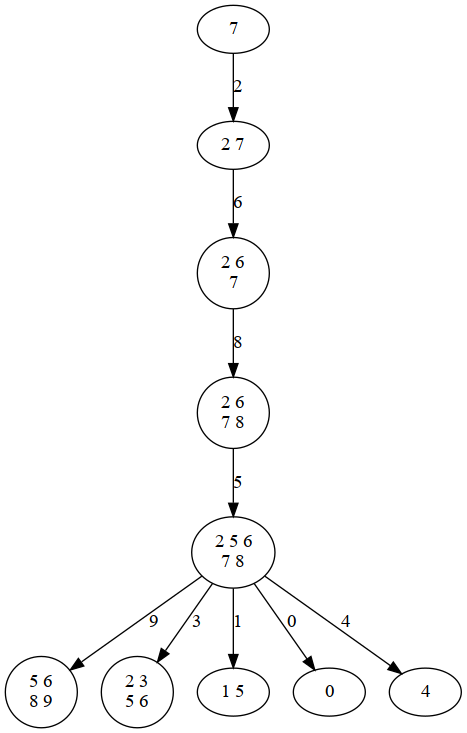

In [4]:
filename="treedecomp"
solver.plot_td(filename,'png')
Image(filename=filename+".png",width=400)

## Interpreting assignents (as colorings)
### Conversion of assignments to coloring dictionaries

Note that the engine returns solutions as (variable to value) assignments. Since the interpretation of such assignments is typically problem-specific, it is left to the user. To display it, we translate the assignment into a printable dictionary (and remove the dummy variable).

In [5]:
def assignment_to_coloring(a):
        colors=["red","cyan","yellow","orange","magenta","green","blue","grey"]
        coloring = {i:colors[v] for i,v in enumerate(a.values())}
        del coloring[0]
        return coloring

## Generating colorings

### Retreiving a best coloring

In [6]:
solver = ir.Optimizer(model)
best_assignment = solver.optimize()
best_coloring = assignment_to_coloring(best_assignment)

print('Optimal coloring:', best_coloring)
print('Colors in cycles:', model.eval_feature(best_assignment,'card'))

Optimal coloring: {1: 'red', 2: 'red', 3: 'yellow', 4: 'red', 5: 'yellow', 6: 'cyan', 7: 'cyan', 8: 'red', 9: 'red'}
Colors in cycles: 12


### Sampling of colorings

Use the weight to control 'optimality'

In [7]:
model.set_feature_weight(0,'card') # weight 0: uniform
solver = ir.Sampler(model)
assignment = solver.sample()
coloring = assignment_to_coloring(assignment)

print('Sampled coloring:', coloring)
print('Colors in cycles:', model.eval_feature(assignment,'card'))

Sampled coloring: {1: 'yellow', 2: 'cyan', 3: 'orange', 4: 'orange', 5: 'orange', 6: 'yellow', 7: 'yellow', 8: 'cyan', 9: 'red'}
Colors in cycles: 13


## Plotting colorings

In [8]:
def plot_coloring(coloring):
    import graphviz

    G = graphviz.Graph('coloring', engine="fdp")

    for i in range(1,numnodes+1):
        G.node(f'{i}', style="filled", color=coloring[i])
    for i,j in edges:
        G.edge(f'{i}',f'{j}')

    return G

[(2, 3, 5, 6), (2, 5, 7, 8), (5, 6, 7, 8), (5, 6, 8, 9)]


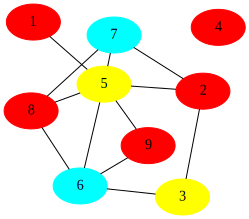

In [9]:
print(cycles)
plot_coloring(best_coloring)

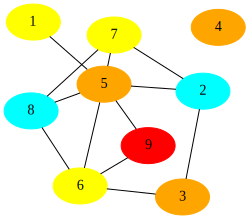

In [10]:
plot_coloring(coloring)